In [1]:
import os
import sys
import numpy as np
import pandas as pd
from functools import partial
from multiprocessing import Pool
from DataProcessor import createData
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

/Users/yuxia/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
path = "./stocks data/Data/"
stock_data_filenames = os.listdir(path)

In [12]:
def logi(x_train, x_test, y_train, y_test):
    
    lr = LogisticRegression()
    lr.fit(x_train, y_train)
    accuracy = lr.score(x_test, y_test)
    probs = lr.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label=1)
    area = roc_auc_score(y_test, [tup[1] for tup in probs])
    
    return accuracy, fpr, tpr, area

def randomf(x_train, x_test, y_train, y_test):
    
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train)
    accuracy = rf.score(x_test, y_test)
    probs = rf.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label=1)
    area = roc_auc_score(y_test, [tup[1] for tup in probs])   
    
    return accuracy, fpr, tpr, area

def XGBC(x_train, x_test, y_train, y_test):
    xgbc = xgb.XGBClassifier(max_depth=6, n_estimators=200, learning_rate=0.15)
    xgbc.fit(x_train, y_train)
    accuracy = xgbc.score(x_test, y_test)
    probs = xgbc.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label=1)
    area = roc_auc_score(y_test, probs[:, 1])
    
    return accuracy, fpr, tpr, area
    
def cal_acurracy(stockname, label_return_period=5, method="Logistic"):
    area = accuracy = 0
    fpr = []
    tpr = []
    path = "./stocks data/Data/" + stockname
    
    try:
        df = pd.read_csv(path)
        data = createData(df, label_return_period=label_return_period, annualized_return=0.1).values
        X = data[:, :-1]
        Y = data[:, -1]
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=18)

        if method == "Logistic":
            accuracy, fpr, tpr, area = logi(x_train, x_test, y_train, y_test)
            
        if method == "RandomForest":
            accuracy, fpr, tpr, area = randomf(x_train, x_test, y_train, y_test)
            
        if method == "xgb":
            accuracy, fpr, tpr, area = XGBC(x_train, x_test, y_train, y_test)

    except:
        print("Error occurs.\nIgnore this stock.")
        
    return accuracy, fpr, tpr, area

def run(file_names, method="Logistic"):
    
    pf = partial(cal_acurracy, method=method)
    p = Pool(processes=10)
    accs = p.map(pf, file_names)
    p.close()
    
    print("Average accuracy: " + str(np.mean([tup[0] for tup in accs])))
    print("Average auc: " + str(np.mean([tup[3] for tup in accs])))

# Example of three different models (with 5 days lag label)

### 1. Logistic regression (All stocks)

In [21]:
run(stock_data_filenames,"Logistic")

Error occurs.
Ignore this stock.
Average accuracy: 0.520409507879
Average auc: 0.508149074123


### 2. RandomForest (All stocks)

In [22]:
run(stock_data_filenames, "RandomForest")

Error occurs.
Ignore this stock.
Average accuracy: 0.696425838929
Average auc: 0.760551967813


### 3. XGBoost (All stocks)

In [23]:
run(stock_data_filenames, "xgb")

Average accuracy: 0.716227776143
Average auc: 0.781647606226


# Performance of models on a random stock

In [18]:
def check_performance(stock_file_name, label_return_period=5):
    path = "./stocks data/Data/" + stock_file_name
    
    df = pd.read_csv(path)
    data = createData(df, label_return_period=label_return_period, annualized_return=0.1).values
    X = data[:, :-1]
    Y = data[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=18)
    accuracy_logi, fpr_logi, tpr_logi, area_logi = logi(x_train, x_test, y_train, y_test)
    accuracy_randomf, fpr_randomf, tpr_randomf, area_randomf = randomf(x_train, x_test, y_train, y_test)
    accuracy_xgb, fpr_xgb, tpr_xgb, area_xgb = XGBC(x_train, x_test, y_train, y_test)

    fig = plt.figure(figsize=(8, 10))
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.xlabel("FPR", size=14)
    plt.ylabel("TPR", size=14)

    plt.plot(fpr_logi, tpr_logi, label="LogisticRegression: {}".format(round(accuracy_logi, 3)))
    plt.plot(fpr_randomf, tpr_randomf, label="RandomForest: {}".format(round(accuracy_randomf, 3)))        
    plt.plot(fpr_xgb, tpr_xgb, label="XGB: {}".format(round(accuracy_xgb, 3)))
    plt.plot([0, 1], [0, 1], c="#000000", label="Diagonal")
    plt.legend()
    plt.title("ROC of " + stock_file_name[:-4] + "(with {} days lag)".format(label_return_period), size=16)
    plt.show()

In [19]:
stock_file_name = stock_data_filenames[int(np.random.random() * len(stock_data_filenames))]

- Performance with labels 1 day lag

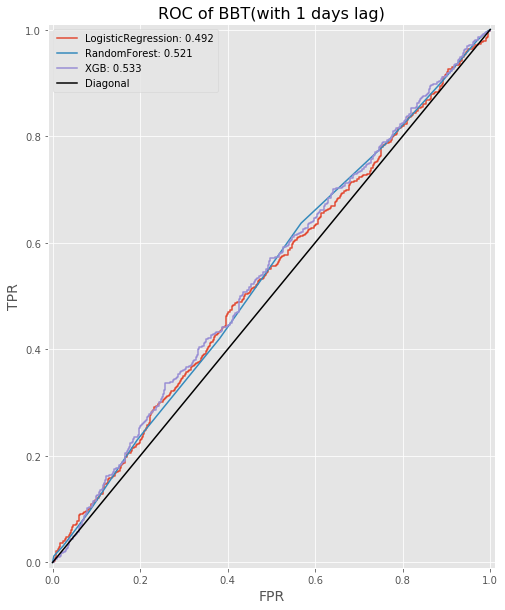

In [24]:
check_performance(stock_file_name, label_return_period=1)

- Performance with labels 2 days lag

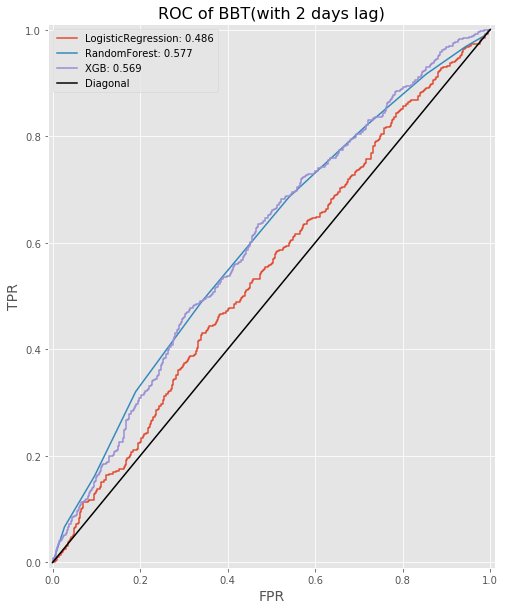

In [25]:
check_performance(stock_file_name, label_return_period=2)

- Performance with labels 5 days lag

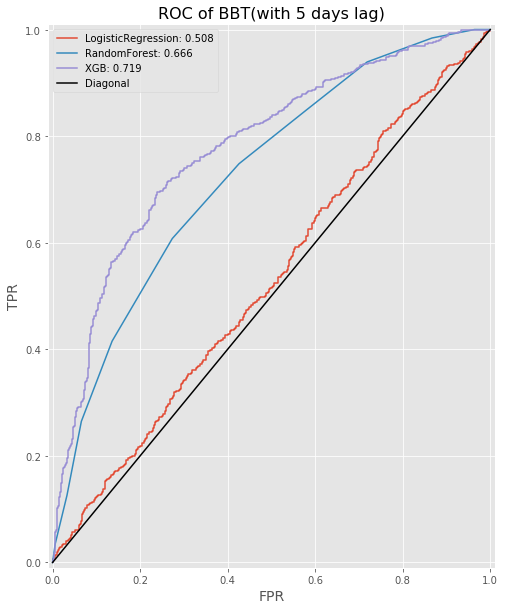

In [26]:
check_performance(stock_file_name, label_return_period=5)

- Performance with labels 10 days lag

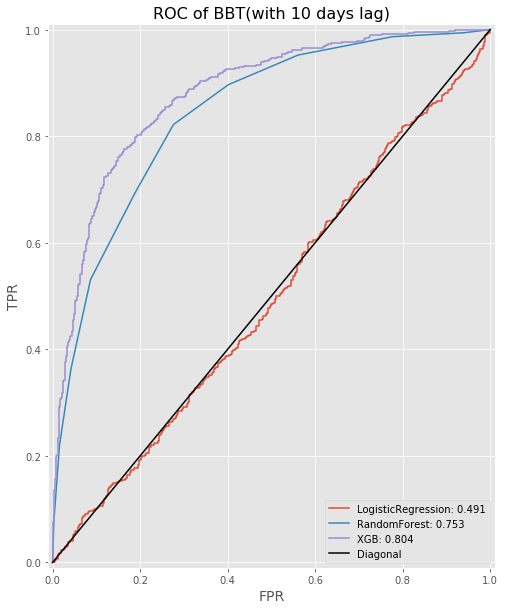

In [27]:
check_performance(stock_file_name, label_return_period=10)

- Performance with label 20 days lag

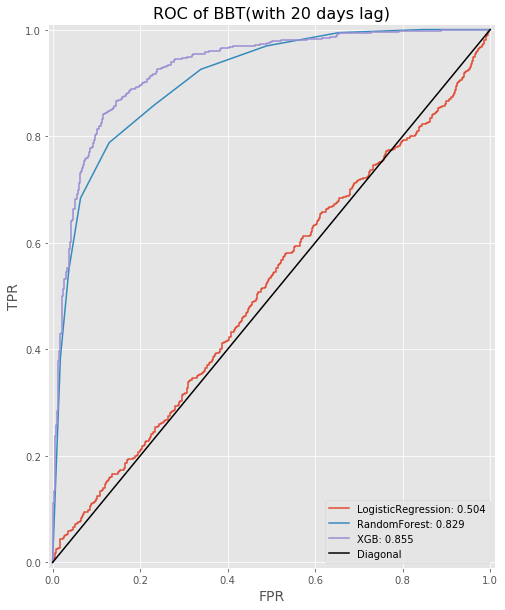

In [20]:
check_performance(stock_file_name, label_return_period=20)